In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys
import os
from pathlib import Path

In [4]:
BASE_PATH = Path(os.path.abspath('')).parent.parent.parent
sys.path.append(str(BASE_PATH))

In [5]:
from bandits.algorithms import *
from bandits.reward_functions import *
from replay_engines.backtester import run_backtest
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import datetime

import matplotlib.pyplot as plt
import scienceplots

%matplotlib inline

# plt.style.use(['science','ieee'])
# plt.style.use(['science','nature'])

In [156]:
portfolio = pd.read_csv('48_Industry_Portfolios_v4.csv')
portfolio = portfolio.fillna(0.)
portfolio["Date"] = pd.to_datetime(portfolio["Date"], utc=True).dt.date
portfolio = portfolio.set_index("Date")

In [157]:
portfolio.columns

Index(['Agric', 'Food ', 'Soda ', 'Beer ', 'Smoke', 'Toys ', 'Fun  ', 'Books',
       'Hshld', 'Clths', 'Hlth ', 'MedEq', 'Drugs', 'Chems', 'Rubbr', 'Txtls',
       'BldMt', 'Cnstr', 'Steel', 'FabPr', 'Mach ', 'ElcEq', 'Autos', 'Aero ',
       'Ships', 'Guns ', 'Gold ', 'Mines', 'Coal ', 'Oil  ', 'Util ', 'Telcm',
       'PerSv', 'BusSv', 'Comps', 'Chips', 'LabEq', 'Paper', 'Boxes', 'Trans',
       'Whlsl', 'Rtail', 'Meals', 'Banks', 'Insur', 'RlEst', 'Fin  ', 'Other'],
      dtype='object')

In [158]:
portfolio['Hlth '] = portfolio['Hlth '].apply(lambda x: 0. if x == -99.99 else x)
portfolio['FabPr'] = portfolio['FabPr'].apply(lambda x: 0. if x == -99.99 else x)
portfolio['Gold '] = portfolio['Gold '].apply(lambda x: 0. if x == -99.99 else x)
portfolio['Soda '] = portfolio['Soda '].apply(lambda x: 0. if x == -99.99 else x)
portfolio['Rubbr'] = portfolio['Rubbr'].apply(lambda x: 0. if x == -99.99 else x)
portfolio['Guns '] = portfolio['Guns '].apply(lambda x: 0. if x == -99.99 else x)

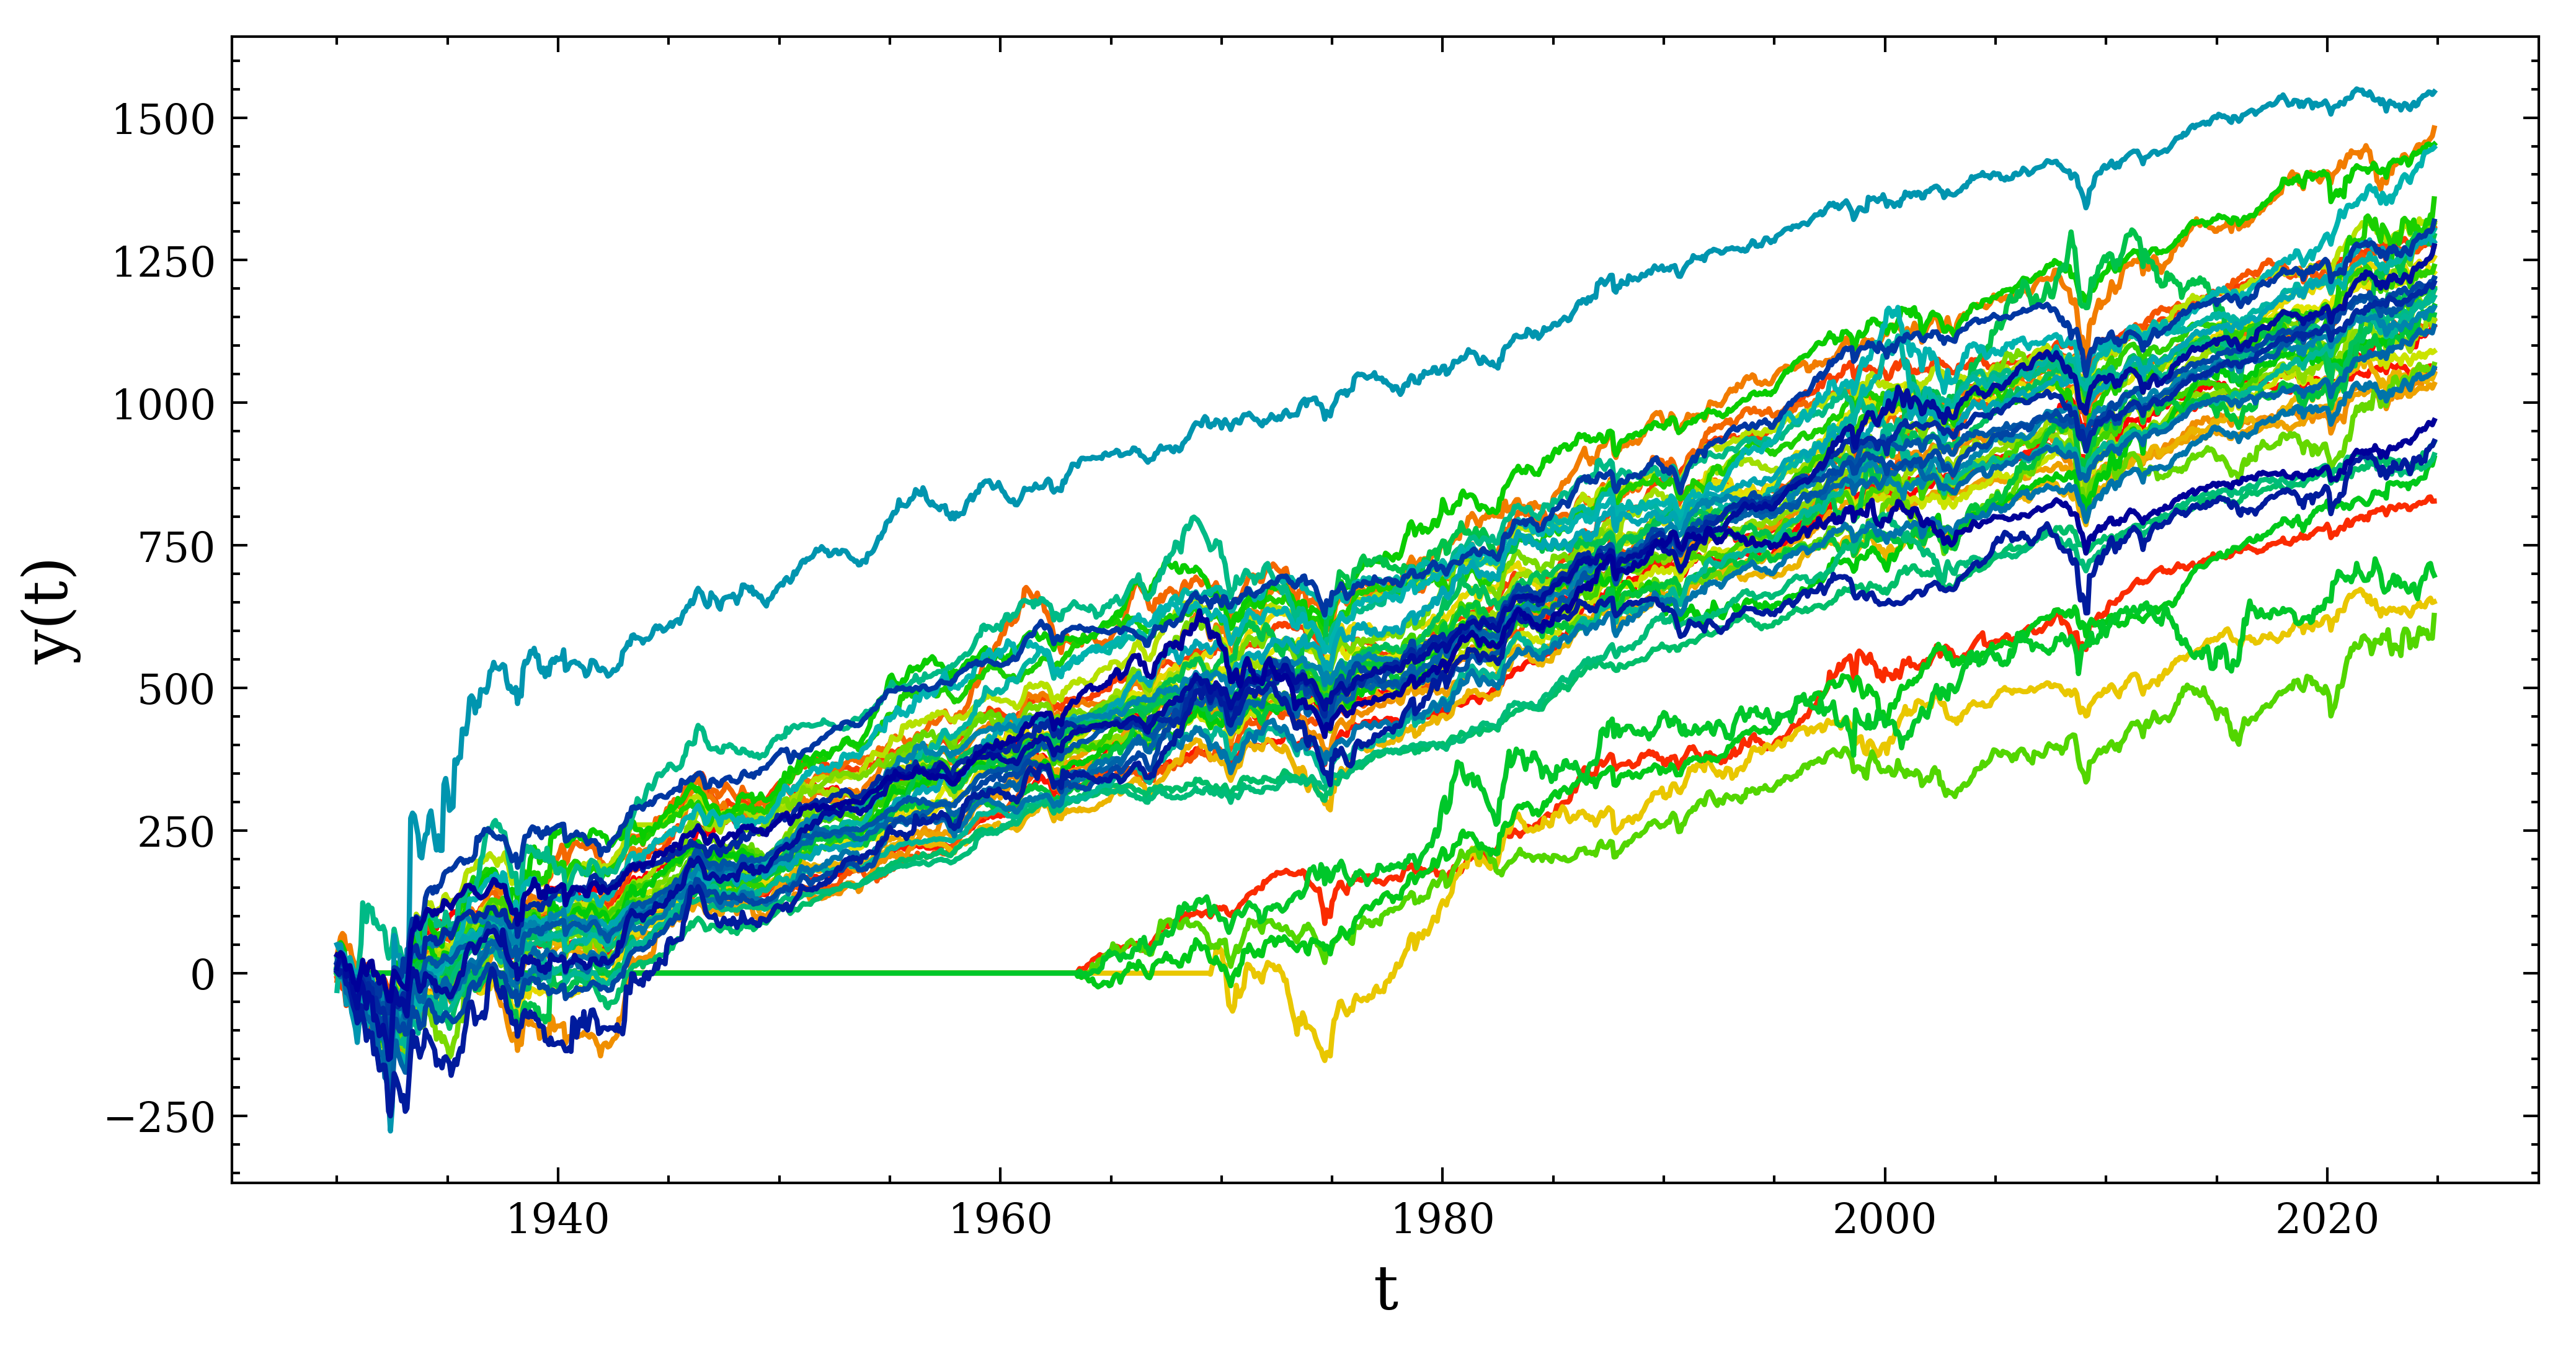

In [160]:
from colour import Color

blue = Color("red", luminance=0.5)
colors = list(blue.range_to(Color("blue", luminance=0.3), len(portfolio.columns)))

with plt.style.context(['science', 'ieee', 'no-latex']):
    fig, ax = plt.subplots(figsize=(8, 4))
    i = 0
    for col in portfolio.columns:
        plt.plot(portfolio[col].cumsum(), color=colors[i].rgb, linestyle="-")
        i += 1
#     plt.legend(portfolio.columns, fontsize=4)
    plt.xlabel('t', fontsize=12)
    plt.ylabel('y(t)', fontsize=12)
    plt.savefig('01_classes.jpg', dpi=600)

## 1- Investigating the Rewards and Regrets

In [161]:
n_sim = 5
shift = 0
polices = {
    "ADTS (min)": {
        "policy_name": "AdaptiveDiscountedThompsonSampling",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.8, "f": "min", "w": 100},
        "agents": [],
    },
    "F-DSW TS (min)": {
        "policy_name": "CavenaghiFDSWTS",
        "args": {"n_arms": portfolio.shape[1], "gamma": 1.0, "f": "min", "n": 30},
        "agents": [],
    },
    "ADTS (max)": {
        "policy_name": "AdaptiveDiscountedThompsonSampling",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.8, "f": "max", "w": 100},
        "agents": [],
    },
    "F-DSW TS (max)": {
        "policy_name": "CavenaghiFDSWTS",
        "args": {"n_arms": portfolio.shape[1], "gamma": 1.0, "f": "max", "n": 30},
        "agents": [],
    },
    "ADTS (mean)": {
        "policy_name": "AdaptiveDiscountedThompsonSampling",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.8, "f": "mean", "w": 100},
        "agents": [],
    },
    "F-DSW TS (mean)": {
        "policy_name": "CavenaghiFDSWTS",
        "args": {"n_arms": portfolio.shape[1], "gamma": 1.0, "f": "mean", "n": 30},
        "agents": [],
    },
    "D TS": {
        "policy_name": "BetaDiscountedThompsonSampling",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.99},
        "agents": [],
    },
    "Classical TS": {
        "policy_name": "ThompsonSampling",
        "args": {"n_arms": portfolio.shape[1]},
        "agents": [],
    },
    "D UCB": {
        "policy_name": "DiscountedUCB1",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.1},
        "agents": [],
    },
    # "SW UCB": {
    #     "policy_name": "SlidingWindowUCB1",
    #     "args": {"n_arms": portfolio.shape[1], "w": 50},
    #     "agents": [],
    # },
    # "UCB1": {
    #     "policy_name": "UCB1",
    #     "args": {"n_arms": portfolio.shape[1]},
    #     "agents": [],
    # },
    # "$\epsilon$-Greedy": {
    #     "policy_name": "EpsilonGreedy",
    #     "args": {"n_arms": portfolio.shape[1], "epsilon": 0.02},
    #     "agents": [],
    # },
}
seeds = list(range(n_sim))
for policy_name, args in polices.items():
    rewards_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    regret_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    chosen_arms_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    for i in tqdm(range(n_sim)):
        kwargs = args["args"].copy()
        kwargs["seed"] = seeds[i]
        rewards, policy = run_backtest(
            policy_name=args["policy_name"],
            policy_args=kwargs,
            portfolio=portfolio,
            arm=ReturnArm()
        )
        rewards_mxt[:, i] = np.array(rewards)
        regret_mxt[:, i] = np.array(policy.regret)
        polices[policy_name]["agents"].append(policy)
    polices[policy_name]["rewards_mxt"] = rewards_mxt
    polices[policy_name]["regret_mxt"] = regret_mxt
    polices[policy_name]["std_reward"] = np.std(rewards_mxt, axis=1)
    polices[policy_name]["mean_reward"] = np.mean(rewards_mxt, axis=1)
    polices[policy_name]["std_regret"] = np.std(regret_mxt, axis=1)
    polices[policy_name]["mean_regret"] = np.mean(regret_mxt, axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.14s/it]


In [162]:
from colour import Color

blue = Color("red", luminance=0.5)
colors = list(blue.range_to(Color("blue", luminance=0.3), len(polices)))

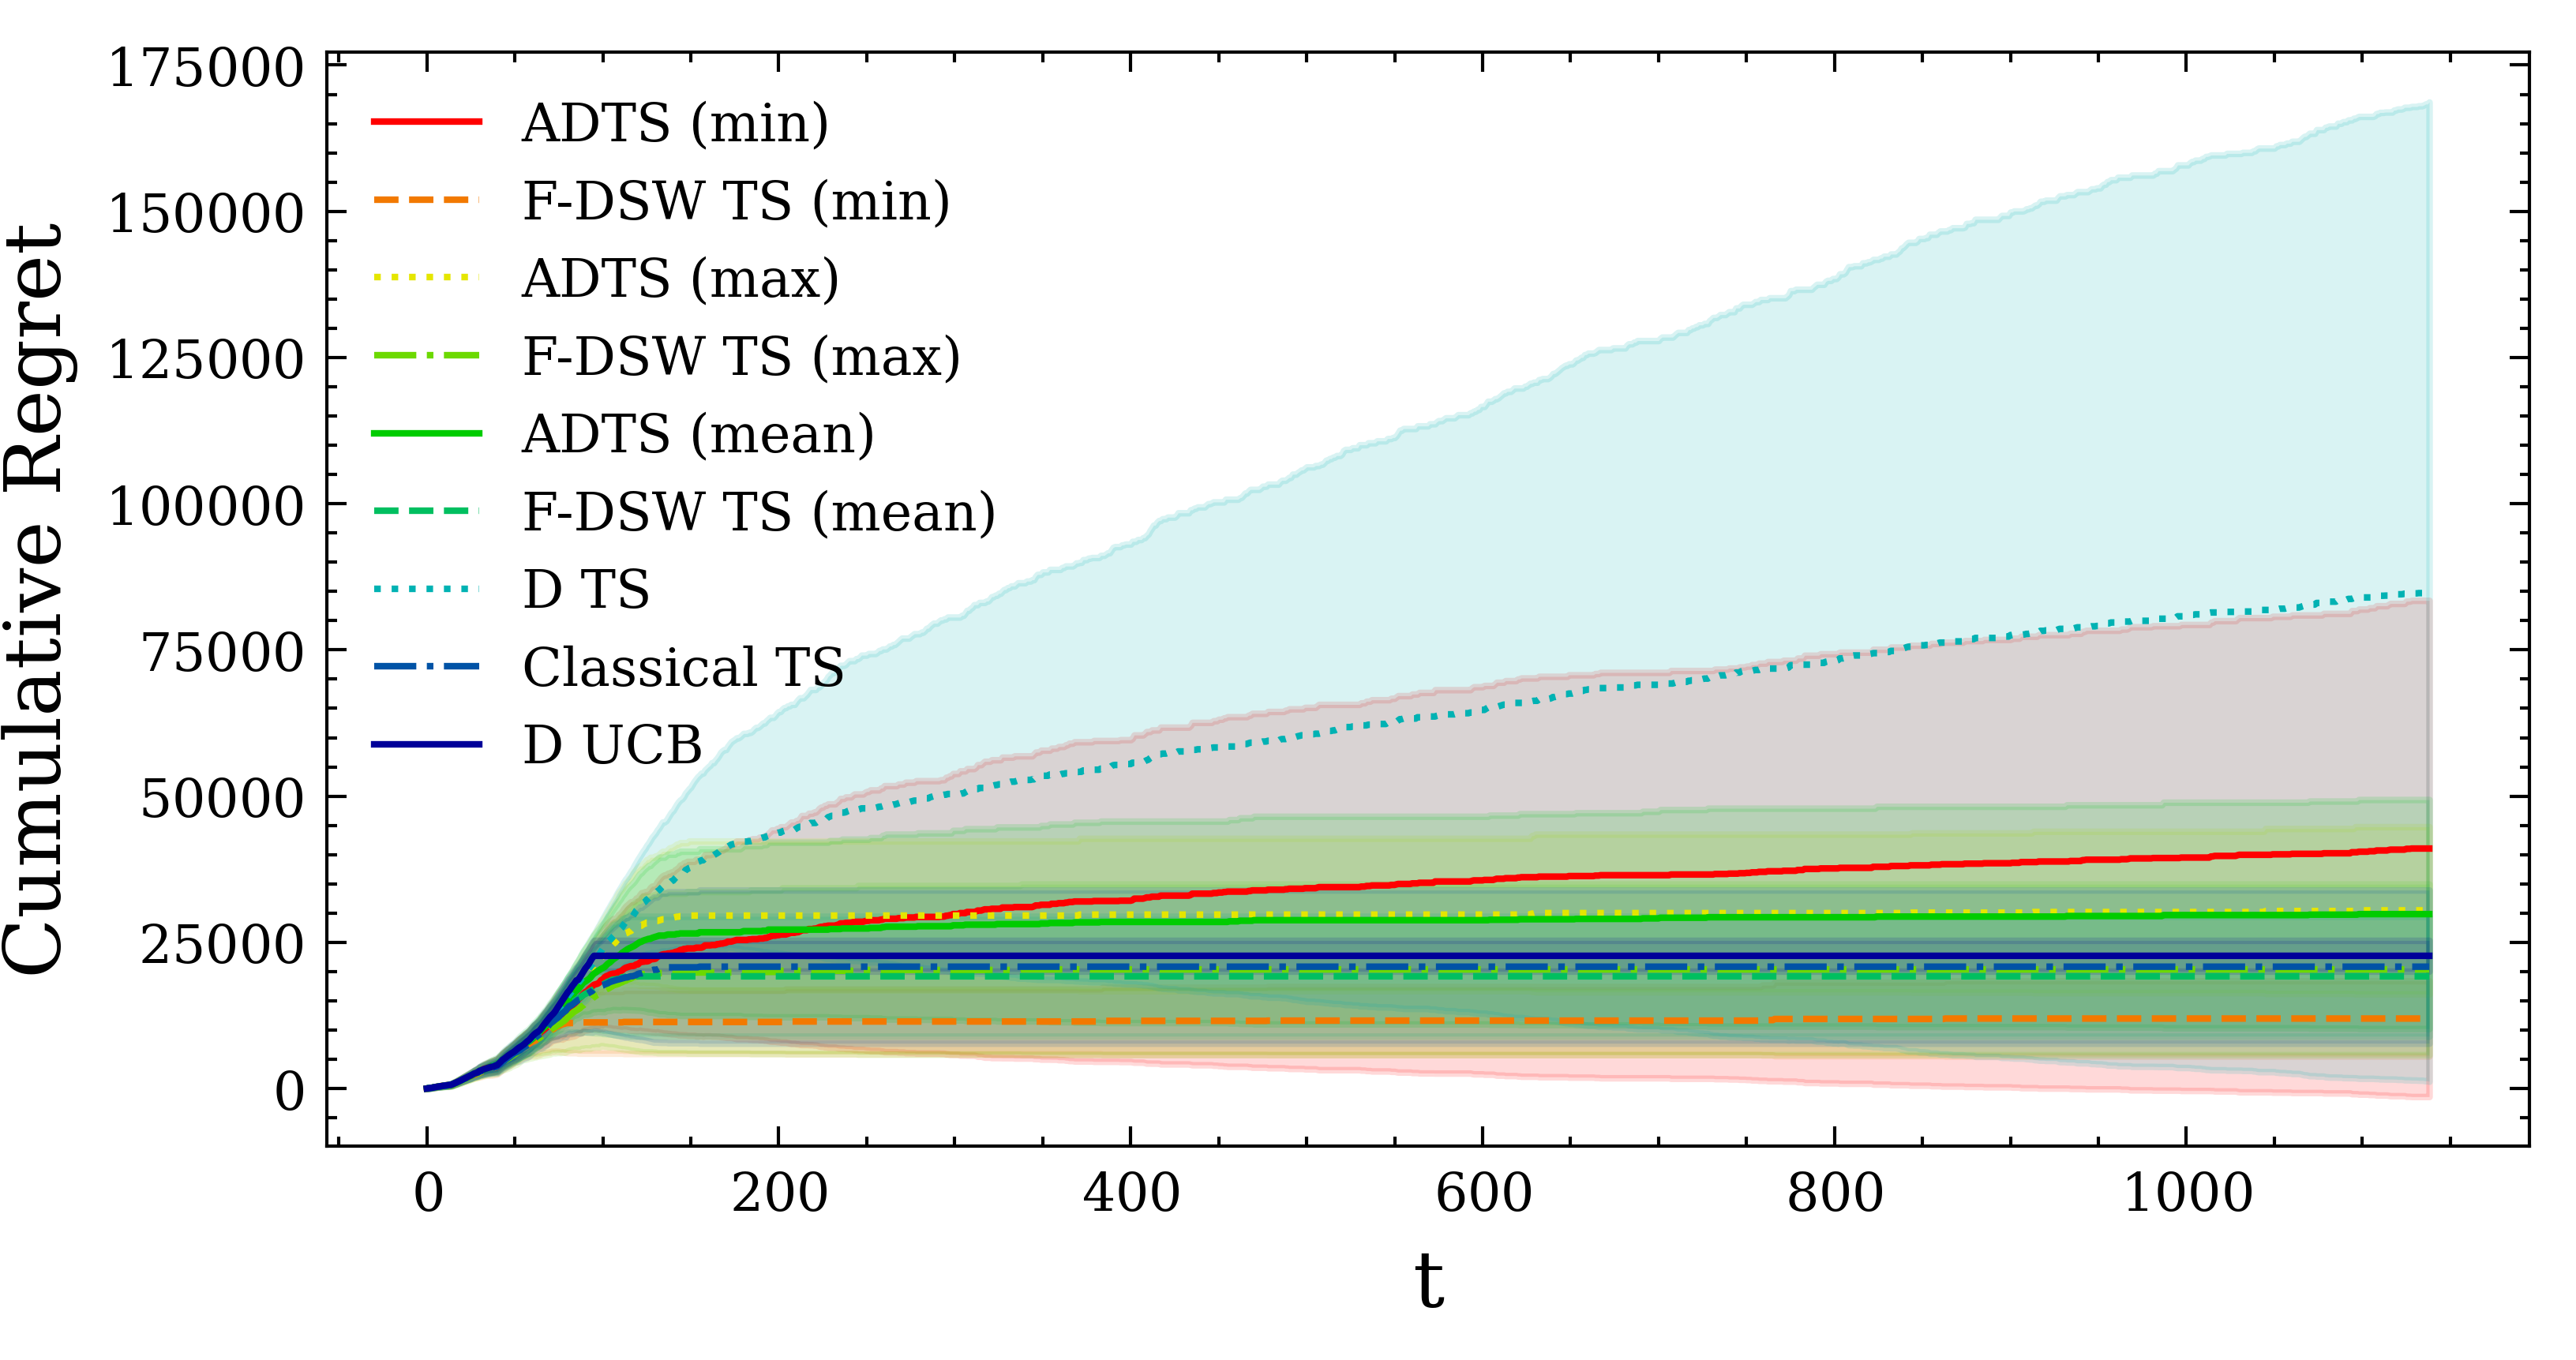

In [163]:
with plt.style.context(['science', 'ieee', 'no-latex']):
    fig, ax = plt.subplots(figsize=(6, 3))
    i = 0
    for policy, output in polices.items():
        plt.plot(np.cumsum(output['mean_regret']), color=colors[i].rgb)
        confidence_interval = 1.96 * output["std_regret"] / np.sqrt(n_sim)
        upper = np.cumsum(output["mean_regret"] + confidence_interval)
        lower = np.cumsum(output["mean_regret"] - confidence_interval)
        plt.fill_between(list(range(len(output['mean_regret']))), upper, lower, color=colors[i].rgb, alpha=0.15, label='_nolegend_')
        i += 1
    plt.legend([p for p in polices.keys()])
    plt.xlabel('t', fontsize=12)
    plt.ylabel('Cumulative Regret', fontsize=12)
    # plt.yscale('log')
#     plt.grid(True)
    plt.savefig('02_cumulative_regrets.jpg', dpi=600)

/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_81223/540851689.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  legend = [f"Oracle: {round(oracle[-1], 2)}"]


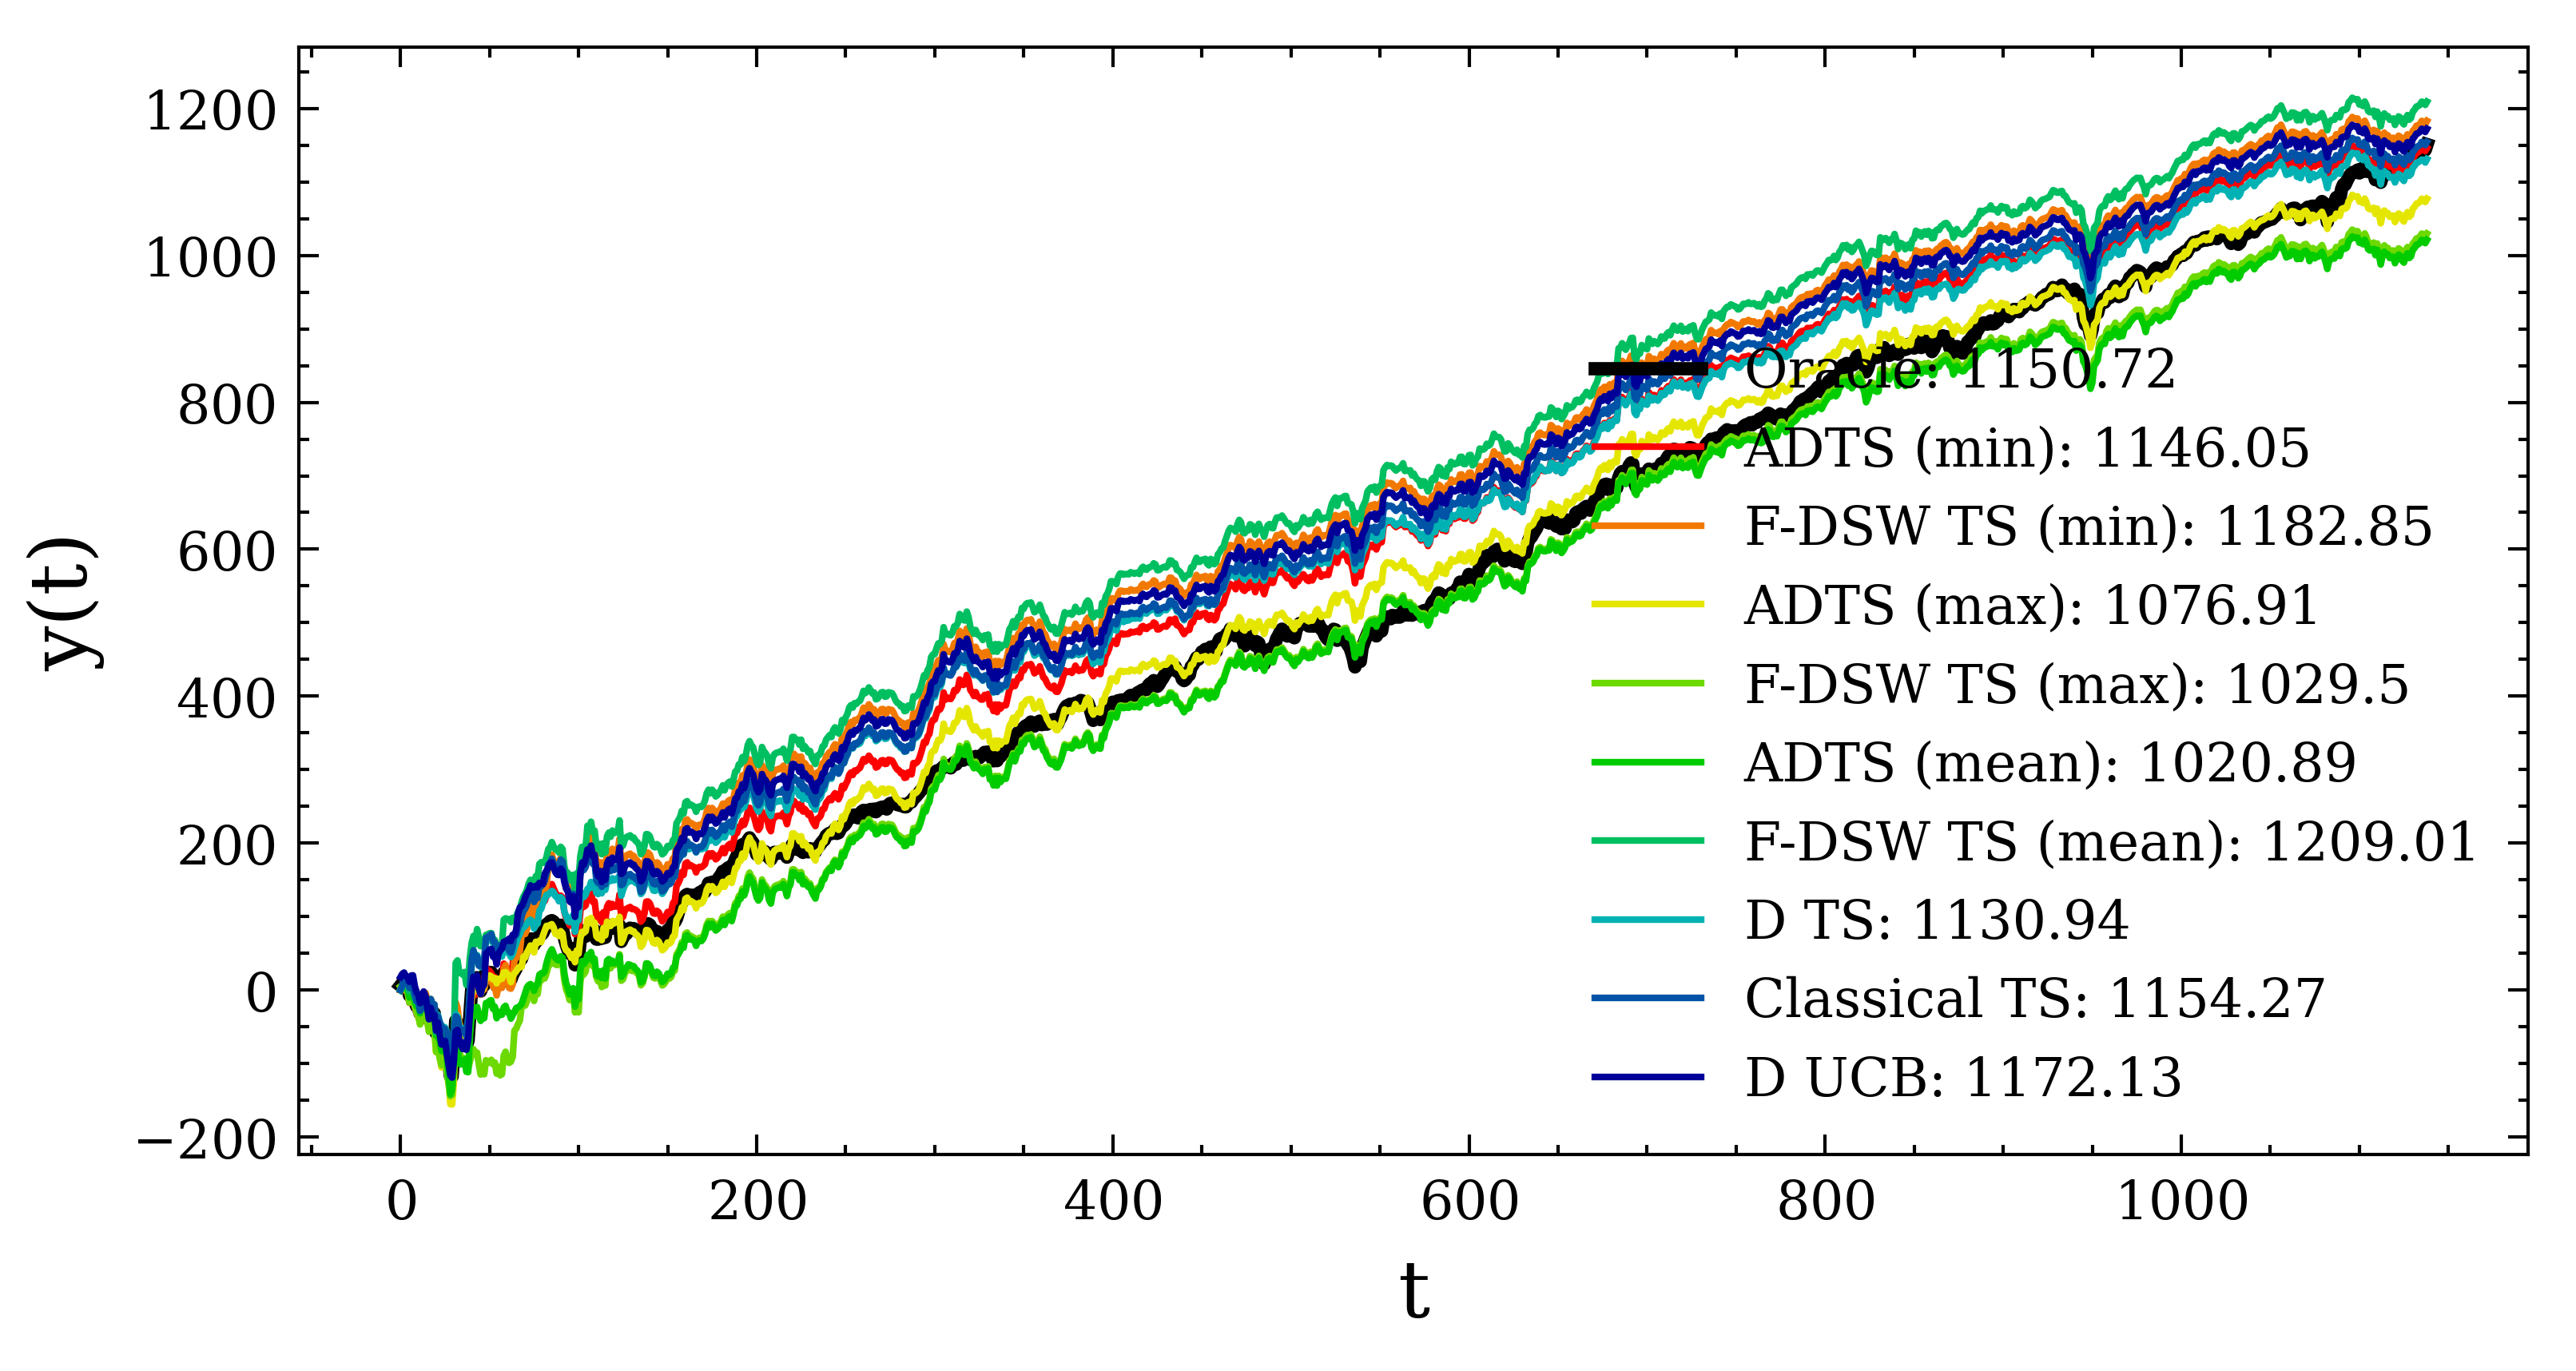

In [164]:
with plt.style.context(['science', 'ieee', 'no-latex']):
    fig, ax = plt.subplots(figsize=(6, 3))
    oracle = portfolio.mean(axis=1).cumsum()
    plt.plot(oracle.values, linewidth=2)
    legend = [f"Oracle: {round(oracle[-1], 2)}"]
    i = 0
    for policy, output in polices.items():
        plt.plot(output["mean_reward"].cumsum(), color=colors[i].rgb, linestyle="-")
        legend.append(f"{policy}: {round(output['mean_reward'].sum(), 2)}")
        i+=1
    
    plt.xlabel('t', fontsize=12)
    plt.ylabel('y(t)', fontsize=12)
    plt.legend(legend)
    plt.savefig('03_rewards_versus_oracle.jpg', dpi=600)

# 2. Tabulating  Accumulated Regrets

In [58]:
n_sim = 100
shift = 0
polices = {
    "ADTS (min)": {
        "policy_name": "AdaptiveDiscountedThompsonSampling",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.8, "f": "min", "w": 30},
        "agents": [],
    },
    "F-DSW TS (min)": {
        "policy_name": "CavenaghiFDSWTS",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.99, "f": "min", "n": 30},
        "agents": [],
    },
    # "ADTS (max)": {
    #     "policy_name": "AdaptiveDiscountedThompsonSampling",
    #     "args": {"n_arms": portfolio.shape[1], "gamma": 0.99, "f": "max", "w": 30},
    #     "agents": [],
    # },
    # "F-DSW TS (max)": {
    #     "policy_name": "CavenaghiFDSWTS",
    #     "args": {"n_arms": portfolio.shape[1], "gamma": 0.99, "f": "max", "n": 30},
    #     "agents": [],
    # },
    # "ADTS (mean)": {
    #     "policy_name": "AdaptiveDiscountedThompsonSampling",
    #     "args": {"n_arms": portfolio.shape[1], "gamma": 0.99, "f": "mean", "w": 30},
    #     "agents": [],
    # },
    # "F-DSW TS (mean)": {
    #     "policy_name": "CavenaghiFDSWTS",
    #     "args": {"n_arms": portfolio.shape[1], "gamma": 0.99, "f": "mean", "n": 30},
    #     "agents": [],
    # },
    "D TS": {
        "policy_name": "BetaDiscountedThompsonSampling",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.99},
        "agents": [],
    },
    "Classical TS": {
        "policy_name": "ThompsonSampling",
        "args": {"n_arms": portfolio.shape[1]},
        "agents": [],
    },
    "D UCB": {
        "policy_name": "DiscountedUCB1",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.1},
        "agents": [],
    },
    "SW UCB": {
        "policy_name": "SlidingWindowUCB1",
        "args": {"n_arms": portfolio.shape[1], "w": 50},
        "agents": [],
    },
    "UCB1": {
        "policy_name": "UCB1",
        "args": {"n_arms": portfolio.shape[1]},
        "agents": [],
    },
    "$\epsilon$-Greedy": {
        "policy_name": "EpsilonGreedy",
        "args": {"n_arms": portfolio.shape[1], "epsilon": 0.02},
        "agents": [],
    },
}
seeds = list(range(n_sim))
for policy_name, args in polices.items():
    rewards_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    regret_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    chosen_arms_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    for i in tqdm(range(n_sim)):
        kwargs = args["args"].copy()
        kwargs["seed"] = seeds[i]
        rewards, policy = run_backtest(
            policy_name=args["policy_name"],
            policy_args=kwargs,
            portfolio=portfolio,
            arm=LastReturnArm()
        )
        rewards_mxt[:, i] = np.array(rewards)
        regret_mxt[:, i] = np.array(policy.regret)
        polices[policy_name]["agents"].append(policy)
    polices[policy_name]["rewards_mxt"] = rewards_mxt
    polices[policy_name]["regret_mxt"] = regret_mxt
    polices[policy_name]["std_reward"] = np.std(rewards_mxt, axis=1)
    polices[policy_name]["mean_reward"] = np.mean(rewards_mxt, axis=1)
    polices[policy_name]["std_regret"] = np.std(regret_mxt, axis=1)
    polices[policy_name]["mean_regret"] = np.mean(regret_mxt, axis=1)

KeyboardInterrupt: 

In [ ]:
import numpy as np

# Generate LaTeX table
table = "\\begin{table}[h]\n"
table += "\\centering\n"
table += "\\begin{tabular}{lcc}\n"
table += "\\hline\n"
table += "Algorithm & Mean Cumulative Regret $\\pm$ Std Dev \\\\\n"
table += "\\hline\n"
for policy, output in polices.items():
    mean_regret = np.cumsum(output["mean_regret"])
    confidence_interval = 1.96 * output["std_regret"] / np.sqrt(n_sim)
    upper = np.cumsum(output["mean_regret"] + confidence_interval)
    lower = np.cumsum(output["mean_regret"] - confidence_interval)
    table += f"{policy} & ${mean_regret[-1]:.1f} \\pm {(upper[-1] - mean_regret[-1]):.1f}$ \\\\\n"
table += "\\hline\n"
table += "\\end{tabular}\n"
table += "\\caption{Comparison of Mean Cumulative Regrets with Std Dev for Various MAB Algorithms (based on 100 simulations)}\n"
table += "\\end{table}\n"

print(table)


## 2- Investigating the effect of discount (gamma) in d TS

In [113]:
gamma_vec = np.linspace(0., 1.0, 11)

In [114]:
gamma_vec

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [116]:
n_sim = 5
polices = {
    f"D TS {i}": {
        "policy_name": "BetaDiscountedThompsonSampling",
        "args": {"n_arms": portfolio.shape[1], "gamma": gamma_vec[i]},
        "agents": [],
    }
    for i in range(len(gamma_vec))
}
polices.update(
    {   
        f"ADTS (min) {i}": {
            "policy_name": "AdaptiveDiscountedThompsonSampling",
            "args": {"n_arms": portfolio.shape[1], "gamma": gamma_vec[i], "f": "min", "w": 30},
            "agents": [],
        }
        for i in range(len(gamma_vec))
    }
)
polices.update(
    {   
        f"FDSWTS (min) {i}": {
            "policy_name": "CavenaghiFDSWTS",
            "args": {"n_arms": portfolio.shape[1], "gamma": gamma_vec[i], "f": "min", "n": 30},
            "agents": [],
        }
        for i in range(len(gamma_vec))
    }
)
polices.update(
    {   
        f"Classical TS {i}": {
            "policy_name": "ThompsonSampling",
            "args": {"n_arms": portfolio.shape[1]},
            "agents": [],
        }
        for i in range(len(gamma_vec))
    }
)

In [117]:
seeds = list(range(n_sim))
for policy_name, args in polices.items():
    rewards_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    regret_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    chosen_arms_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    for i in tqdm(range(n_sim)):
        kwargs = args["args"].copy()
        kwargs["seed"] = seeds[i]
        rewards, policy = run_backtest(
            policy_name=args["policy_name"],
            policy_args=kwargs,
            portfolio=portfolio,
            arm=ReturnArm()
        )
        rewards_mxt[:, i] = np.array(rewards)
        regret_mxt[:, i] = np.array(policy.regret)
        polices[policy_name]["agents"].append(policy)
    polices[policy_name]["regret"] = np.mean(regret_mxt, axis=1).mean()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.89s/it]
/Users/gfonseca/Desktop/Doutorado - EEC-I/Pesquisa/bandits-lib/venv/lib/python3.9/site-packages/multi_armed_bandit/algorithms/bernoulli_dist/min_dsw_ts.py:33: RuntimeWarning: invalid value encountered in scalar divide00:00<?, ?it/s]
  self._mean_trace[a].append(self._betas[a][1] / (self._betas[a][1] + self._betas[a][0]))
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]


In [118]:
groups = ["D TS", "ADTS (min)", "FDSWTS (min)", "Classical TS"]
results_dict = {}
for g in groups:
    results_dict[g] = {
        "gamma_vec": gamma_vec,
        "regret": []
    }
    for k, v in polices.items():
        if g in k:
            results_dict[g]["regret"].append(v["regret"])

/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_81223/1115535588.py:16: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(results_dict["D TS"]["gamma_vec"], results_dict["D TS"]["regret"], "-o", markersize=4, color=colors[0].rgb, linestyle="-.")
/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_81223/1115535588.py:17: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(results_dict["ADTS (min)"]["gamma_vec"], results_dict["ADTS (min)"]["regret"], "-s", markersize=2, color=colors[1].rgb, linestyle="-.")
/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_81223/1115535588.py:18: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The k

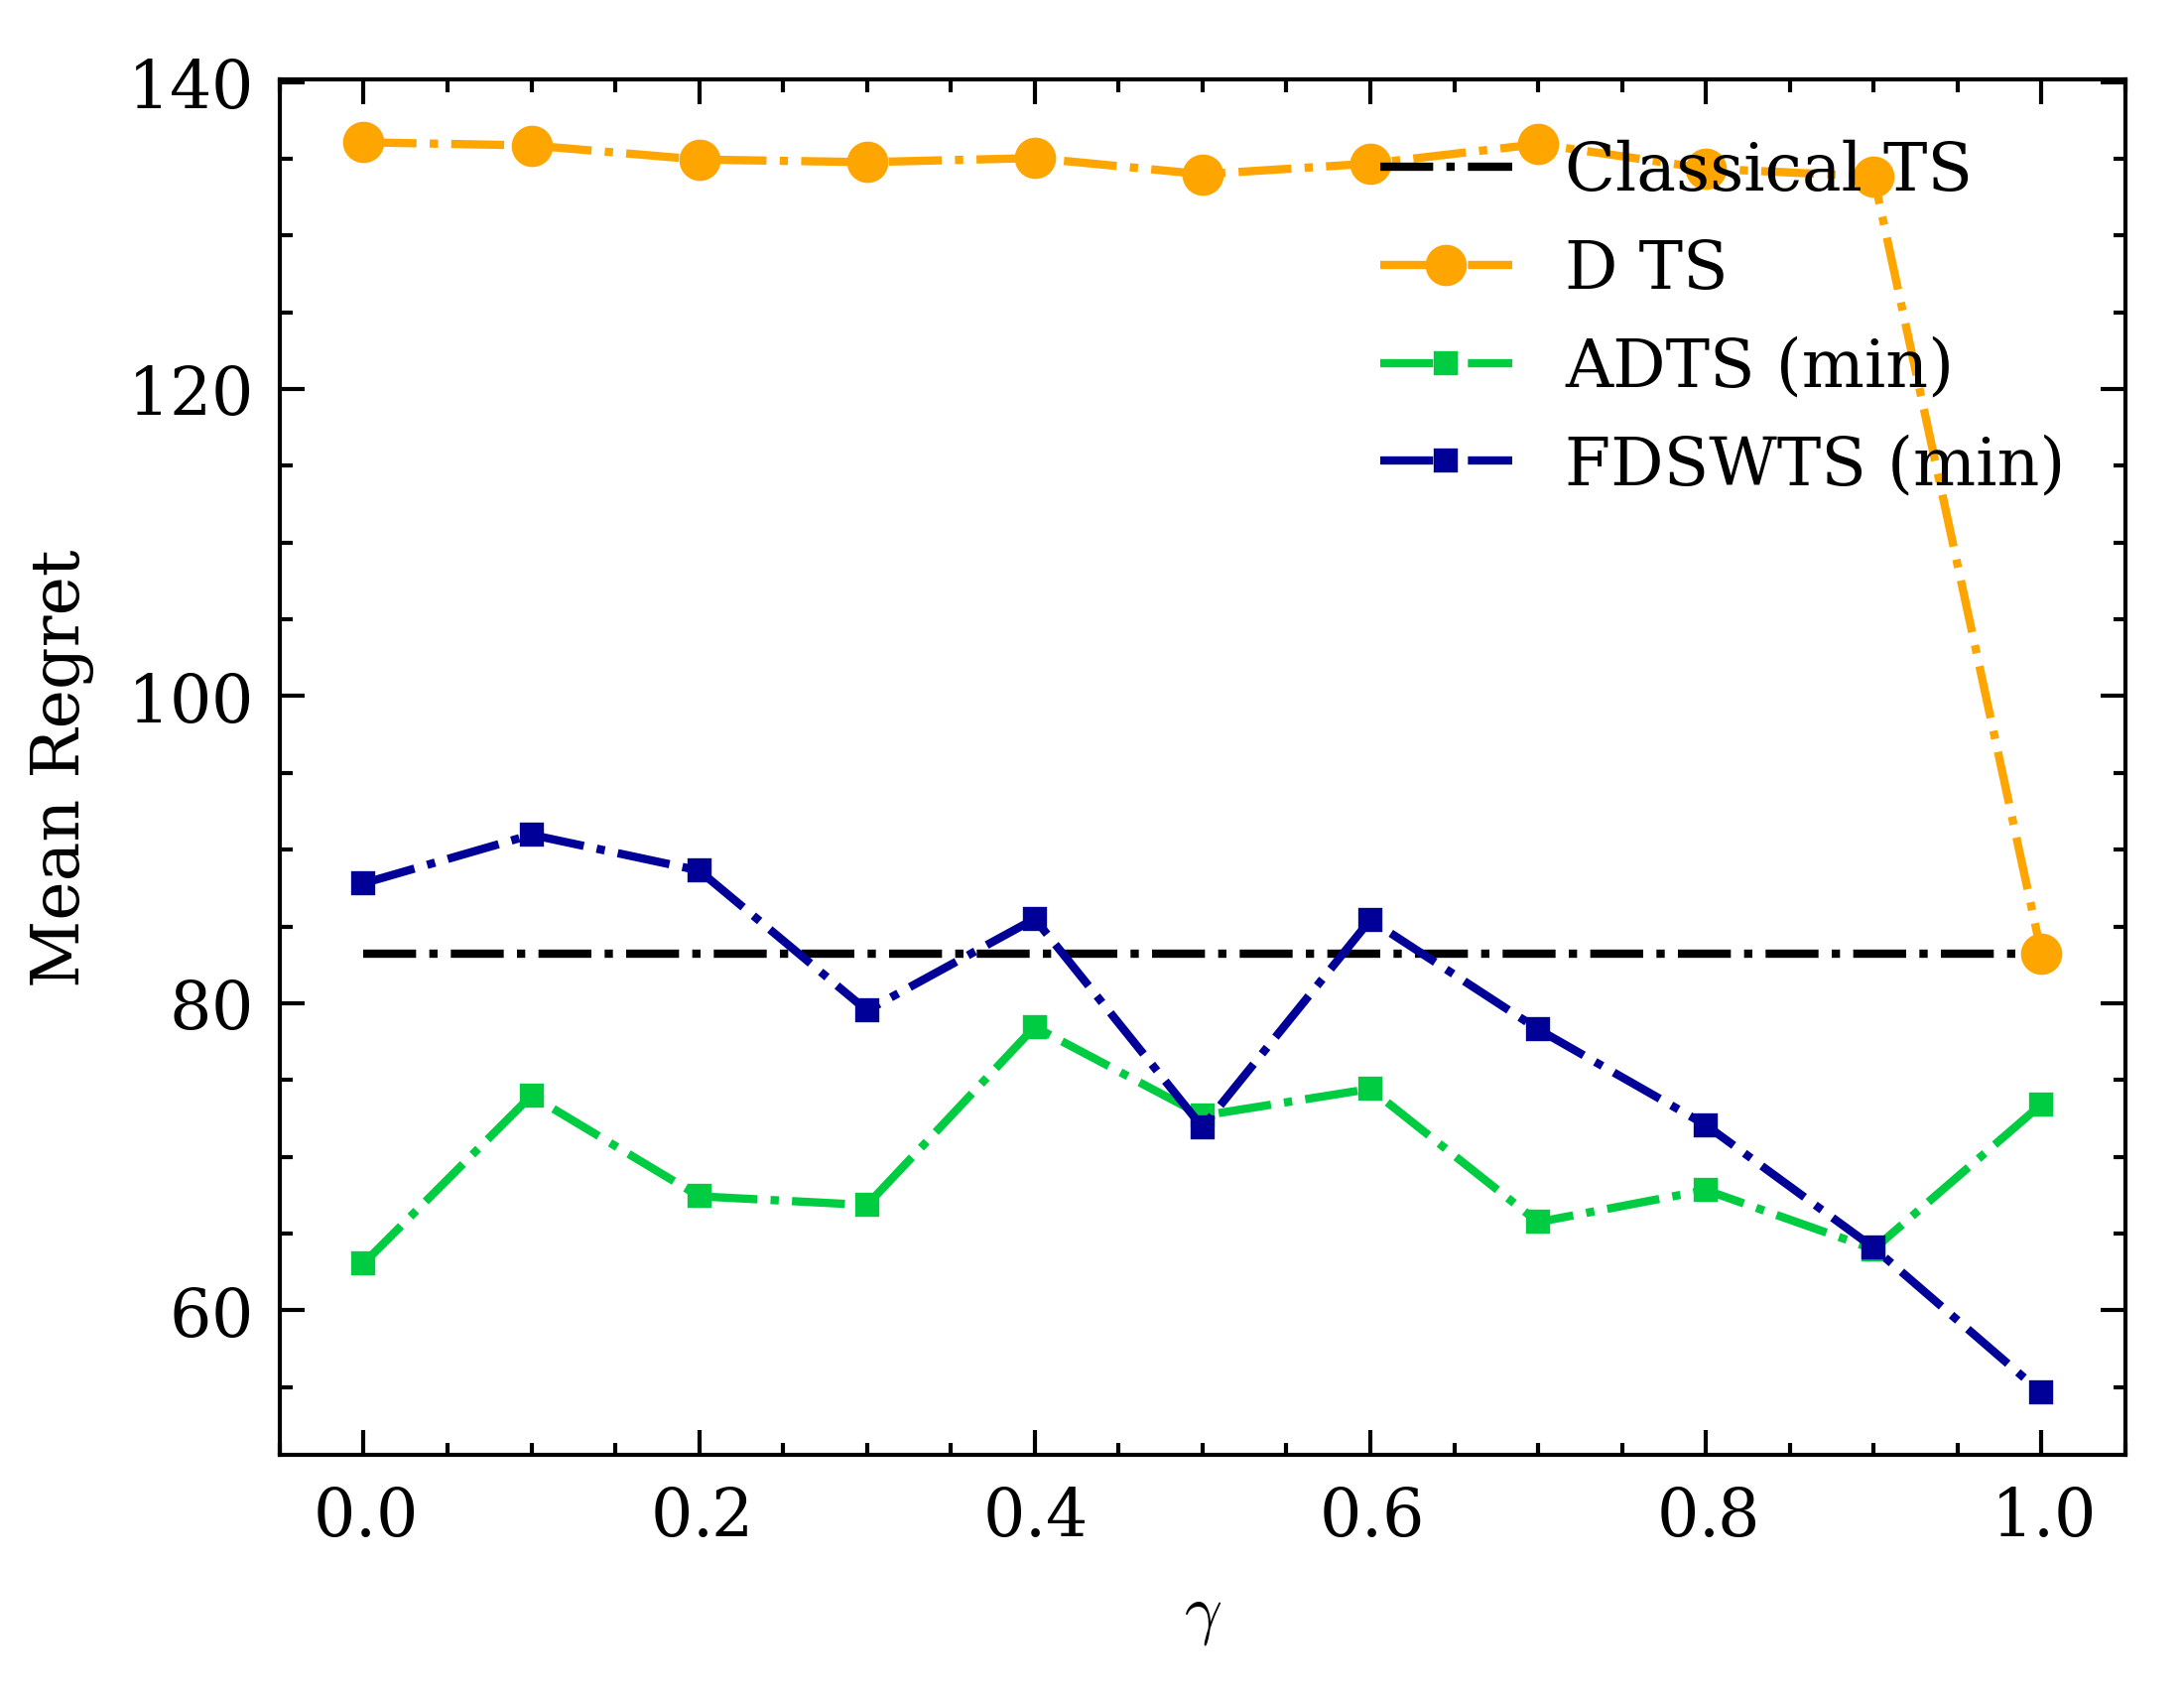

In [119]:
from colour import Color

blue = Color("orange")
colors = list(blue.range_to(Color("blue", luminance=0.3), len(results_dict)-1))

x_min = 0.79
x_max = 1.01
y_min = 0.
y_max = 1.5

with plt.style.context(['science', 'ieee', 'no-latex']):
    fig, ax = plt.subplots(figsize=(4, 3))
    legend = []
    i = 0
    plt.plot(results_dict["Classical TS"]["gamma_vec"], results_dict["Classical TS"]["regret"], color="k", linestyle="-.")
    plt.plot(results_dict["D TS"]["gamma_vec"], results_dict["D TS"]["regret"], "-o", markersize=4, color=colors[0].rgb, linestyle="-.")
    plt.plot(results_dict["ADTS (min)"]["gamma_vec"], results_dict["ADTS (min)"]["regret"], "-s", markersize=2, color=colors[1].rgb, linestyle="-.")
    plt.plot(results_dict["FDSWTS (min)"]["gamma_vec"], results_dict["FDSWTS (min)"]["regret"], "-s", markersize=2, color=colors[2].rgb, linestyle="-.")
    
    # plt.plot([x_min, x_min], [y_min, y_max], color='r', linewidth=1, linestyle="--")
    # plt.plot([x_min, x_max], [y_max, y_max], color='r', linewidth=1, linestyle="--")
    # plt.plot([x_max, x_max], [y_min, y_max], color='r', linewidth=1, linestyle="--")
    # plt.plot([x_min, x_max], [y_min, y_min], color='r', linewidth=1, linestyle="--")
    
    plt.xlabel(r'$\gamma$')
    plt.ylabel('Mean Regret')
    plt.legend(["Classical TS", "D TS", "ADTS (min)", "FDSWTS (min)"])
    plt.savefig('04_effect_of_gamma.jpg', dpi=600)

/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_81223/2558972403.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(results_dict["D TS"]["gamma_vec"], results_dict["D TS"]["regret"], "-o", markersize=4, color=colors[0].rgb, linestyle="-.")
/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_81223/2558972403.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(results_dict["ADTS (min)"]["gamma_vec"], results_dict["ADTS (min)"]["regret"], "-s", markersize=2, color=colors[1].rgb, linestyle="-.")
/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_81223/2558972403.py:13: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The k

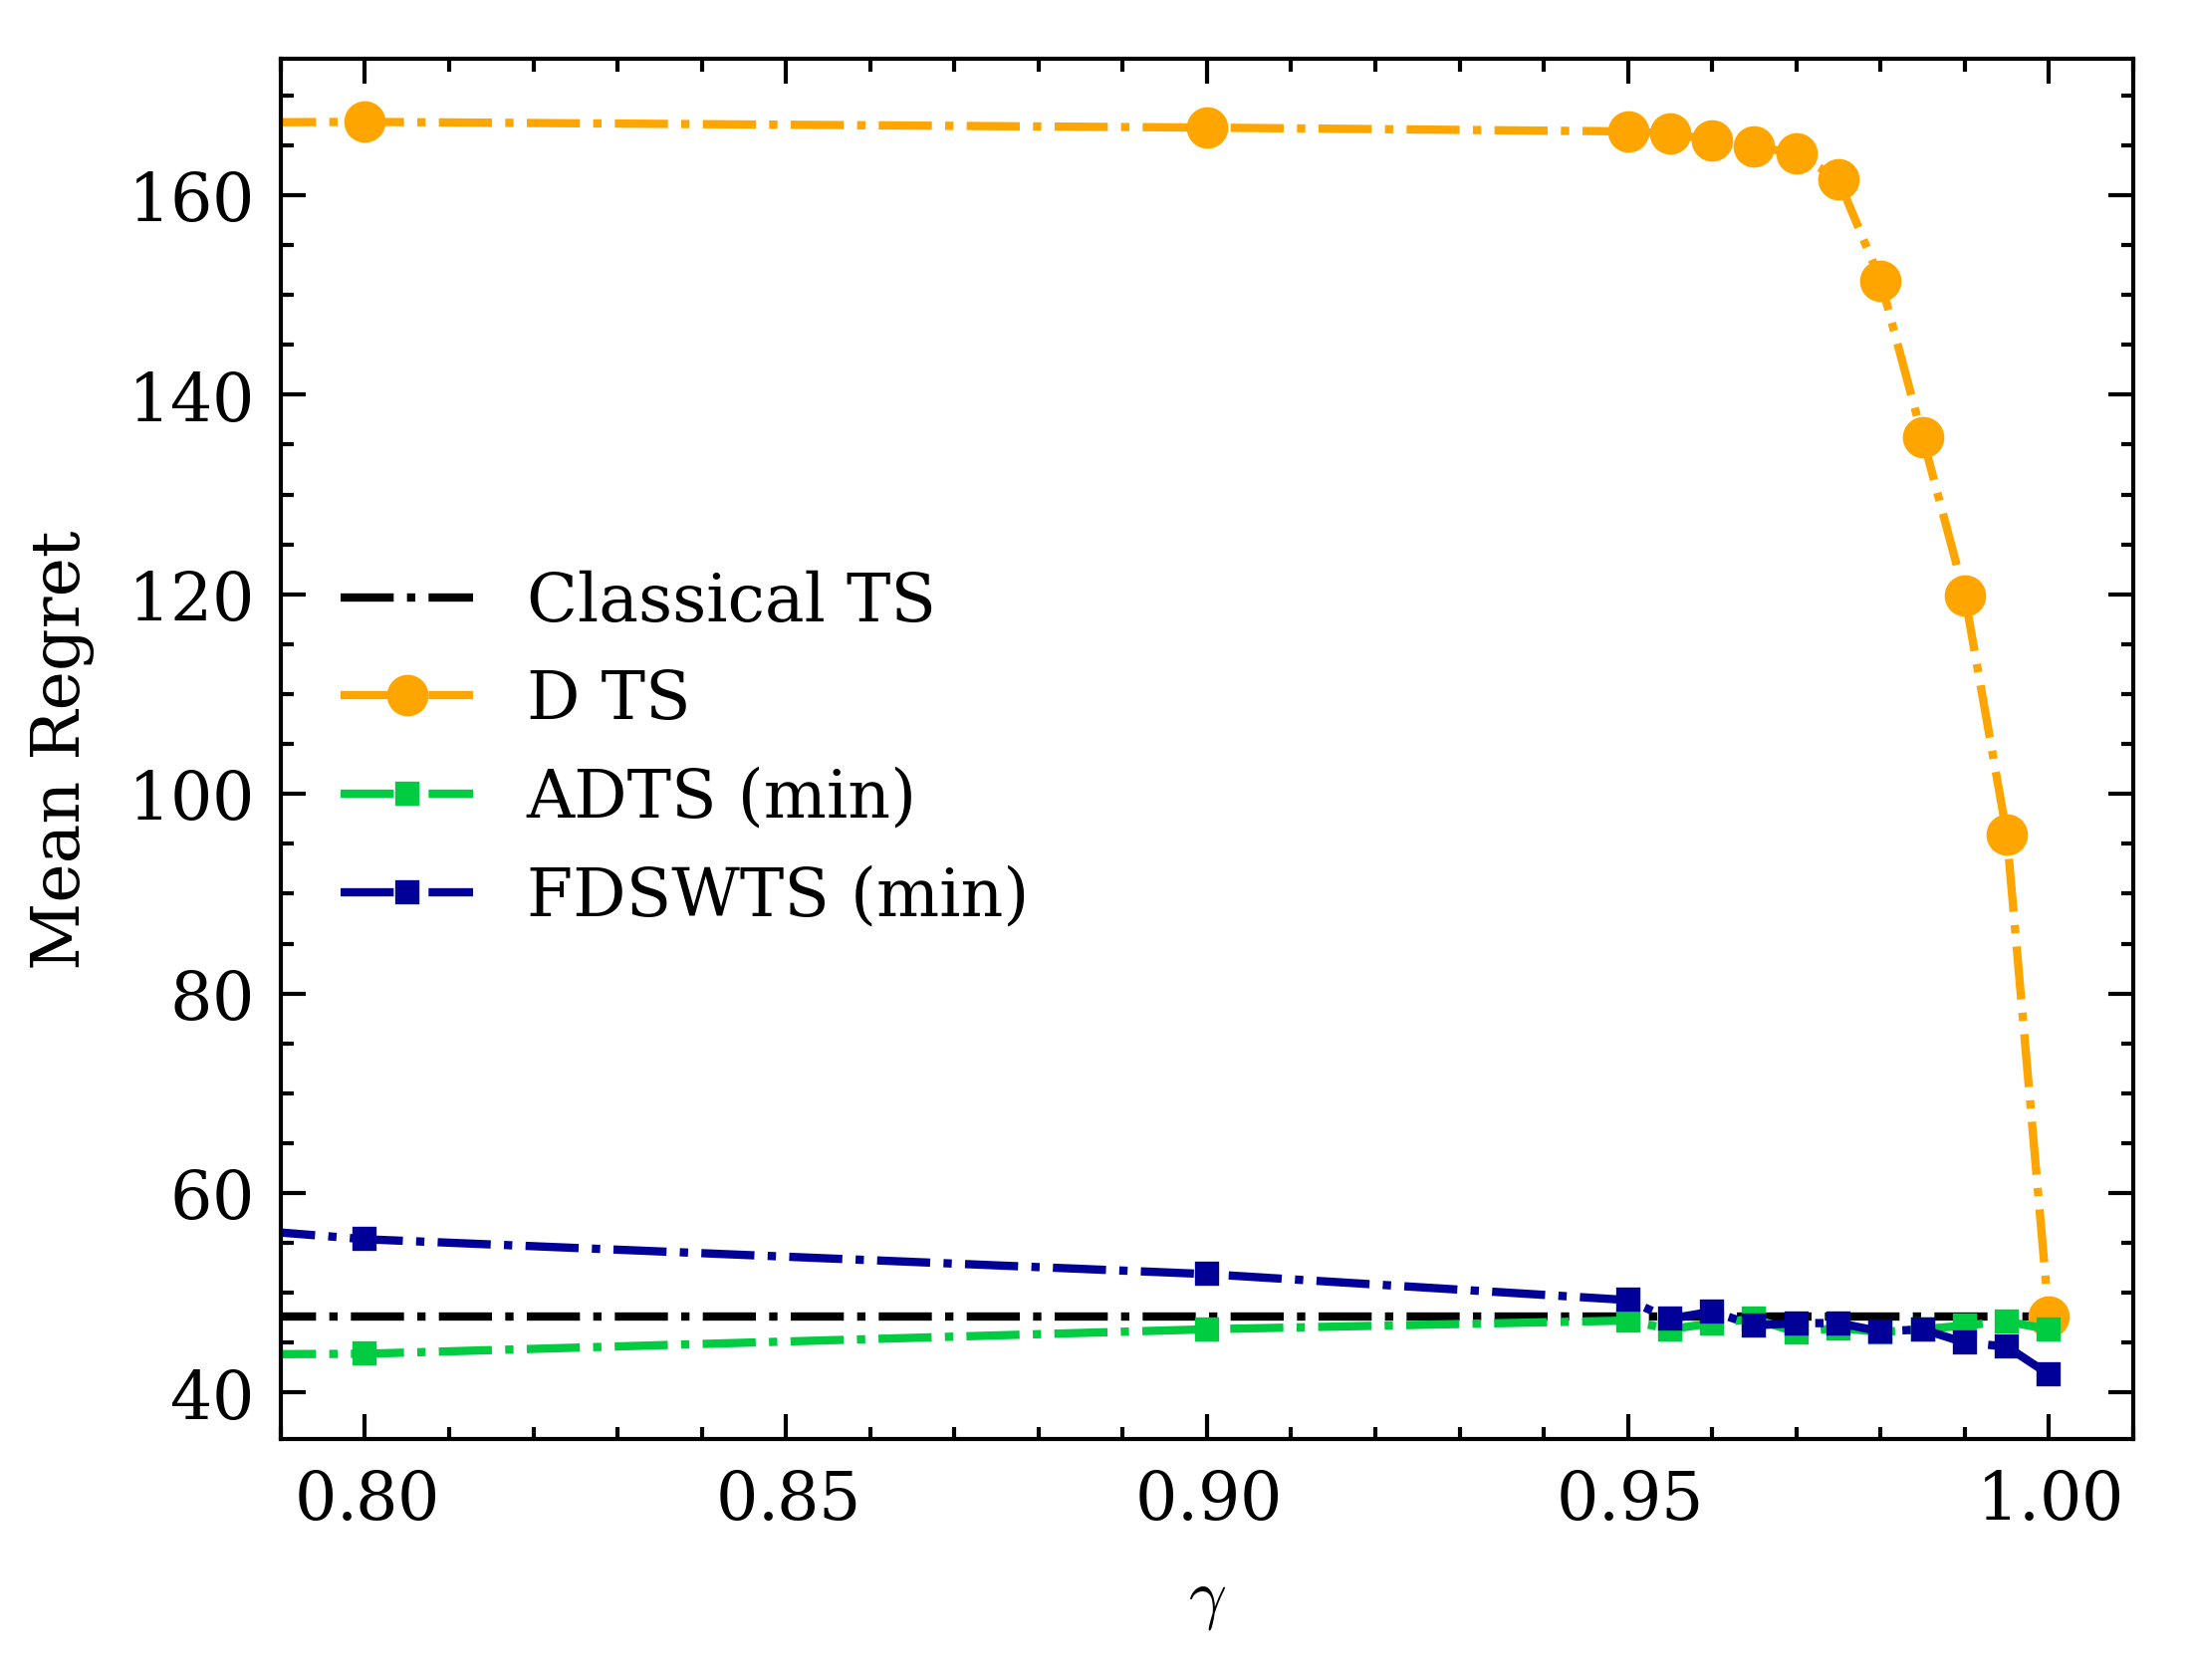

In [56]:
from colour import Color

blue = Color("orange")
colors = list(blue.range_to(Color("blue", luminance=0.3), len(results_dict)-1))

with plt.style.context(['science', 'ieee', 'no-latex']):
    fig, ax = plt.subplots(figsize=(4, 3))
    legend = []
    i = 0
    plt.plot(results_dict["Classical TS"]["gamma_vec"], results_dict["Classical TS"]["regret"], color="k", linestyle="-.")
    plt.plot(results_dict["D TS"]["gamma_vec"], results_dict["D TS"]["regret"], "-o", markersize=4, color=colors[0].rgb, linestyle="-.")
    plt.plot(results_dict["ADTS (min)"]["gamma_vec"], results_dict["ADTS (min)"]["regret"], "-s", markersize=2, color=colors[1].rgb, linestyle="-.")
    plt.plot(results_dict["FDSWTS (min)"]["gamma_vec"], results_dict["FDSWTS (min)"]["regret"], "-s", markersize=2, color=colors[2].rgb, linestyle="-.")
    
    plt.xlabel(r'$\gamma$')
    plt.ylabel('Mean Regret')
    plt.legend(["Classical TS", "D TS", "ADTS (min)", "FDSWTS (min)"])
    plt.xlim([0.79, 1.01])
    plt.savefig('04_effect_of_gamma_zoom.jpg', dpi=600)

## 3- Investigating the window size (w) on sw-d TS

In [63]:
w_vec = np.linspace(0, 100, 11)

In [64]:
w_vec[0] = 1

In [65]:
w_vec

array([  1.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.])

In [120]:
n_sim = 3
polices = {
    f"D TS {i}": {
        "policy_name": "BetaDiscountedThompsonSampling",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.98},
        "agents": [],
    }
    for i in range(len(w_vec))
}
polices.update(
    {   
        f"ADTS (min) {i}": {
            "policy_name": "AdaptiveDiscountedThompsonSampling",
            "args": {"n_arms": portfolio.shape[1], "gamma": 0.9, "f": "min", "w": int(w_vec[i])},
            "agents": [],
        }
        for i in range(len(w_vec))
    }
)
polices.update(
    {   
        f"ADTS (mean) {i}": {
            "policy_name": "AdaptiveDiscountedThompsonSampling",
            "args": {"n_arms": portfolio.shape[1], "gamma": 0.9, "f": "mean", "w": int(w_vec[i])},
            "agents": [],
        }
        for i in range(len(w_vec))
    }
)
polices.update(
    {   
        f"ADTS (max) {i}": {
            "policy_name": "AdaptiveDiscountedThompsonSampling",
            "args": {"n_arms": portfolio.shape[1], "gamma": 0.9, "f": "max", "w": int(w_vec[i])},
            "agents": [],
        }
        for i in range(len(w_vec))
    }
)
polices.update(
    {   
        f"FDSWTS (min) {i}": {
            "policy_name": "CavenaghiFDSWTS",
            "args": {"n_arms": portfolio.shape[1], "gamma": 1.0, "f": "min", "n": int(w_vec[i])},
            "agents": [],
        }
        for i in range(len(w_vec))
    }
)
polices.update(
    {   
        f"FDSWTS (mean) {i}": {
            "policy_name": "CavenaghiFDSWTS",
            "args": {"n_arms": portfolio.shape[1], "gamma": 1.0, "f": "mean", "n": int(w_vec[i])},
            "agents": [],
        }
        for i in range(len(w_vec))
    }
)
polices.update(
    {   
        f"FDSWTS (max) {i}": {
            "policy_name": "CavenaghiFDSWTS",
            "args": {"n_arms": portfolio.shape[1], "gamma": 1.0, "f": "max", "n": int(w_vec[i])},
            "agents": [],
        }
        for i in range(len(w_vec))
    }
)

In [121]:
seeds = list(range(n_sim))
for policy_name, args in polices.items():
    rewards_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    regret_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    chosen_arms_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    for i in tqdm(range(n_sim)):
        kwargs = args["args"].copy()
        kwargs["seed"] = seeds[i]
        rewards, policy = run_backtest(
            policy_name=args["policy_name"],
            policy_args=kwargs,
            portfolio=portfolio,
            arm=LastReturnArm()
        )
        rewards_mxt[:, i] = np.array(rewards)
        regret_mxt[:, i] = np.array(policy.regret)
        polices[policy_name]["agents"].append(policy)
    polices[policy_name]["regret"] = np.mean(regret_mxt, axis=1).mean()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.51s/it]


In [122]:
# groups = ["d TS", "min d-sw TS", "avg d-sw TS", "max d-sw TS", "Classical TS"]
groups = ["D TS", "ADTS (min)", "ADTS (mean)", "ADTS (max)", "FDSWTS (min)", "FDSWTS (mean)", "FDSWTS (max)"]
results_dict = {}
for g in groups:
    results_dict[g] = {
        "w_vec": w_vec,
        "regret": []
    }
    for k, v in polices.items():
        if g in k:
            results_dict[g]["regret"].append(v["regret"])

/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_81223/2830565929.py:16: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(results_dict["ADTS (min)"]["w_vec"], results_dict["ADTS (min)"]["regret"], "-s", markersize=2, color=colors[0].rgb, linestyle="-")
/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_81223/2830565929.py:17: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(results_dict["ADTS (mean)"]["w_vec"], results_dict["ADTS (mean)"]["regret"], "-o", markersize=2, color=colors[1].rgb, linestyle="-")
/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_81223/2830565929.py:18: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-^" (-> linestyle='-'). T

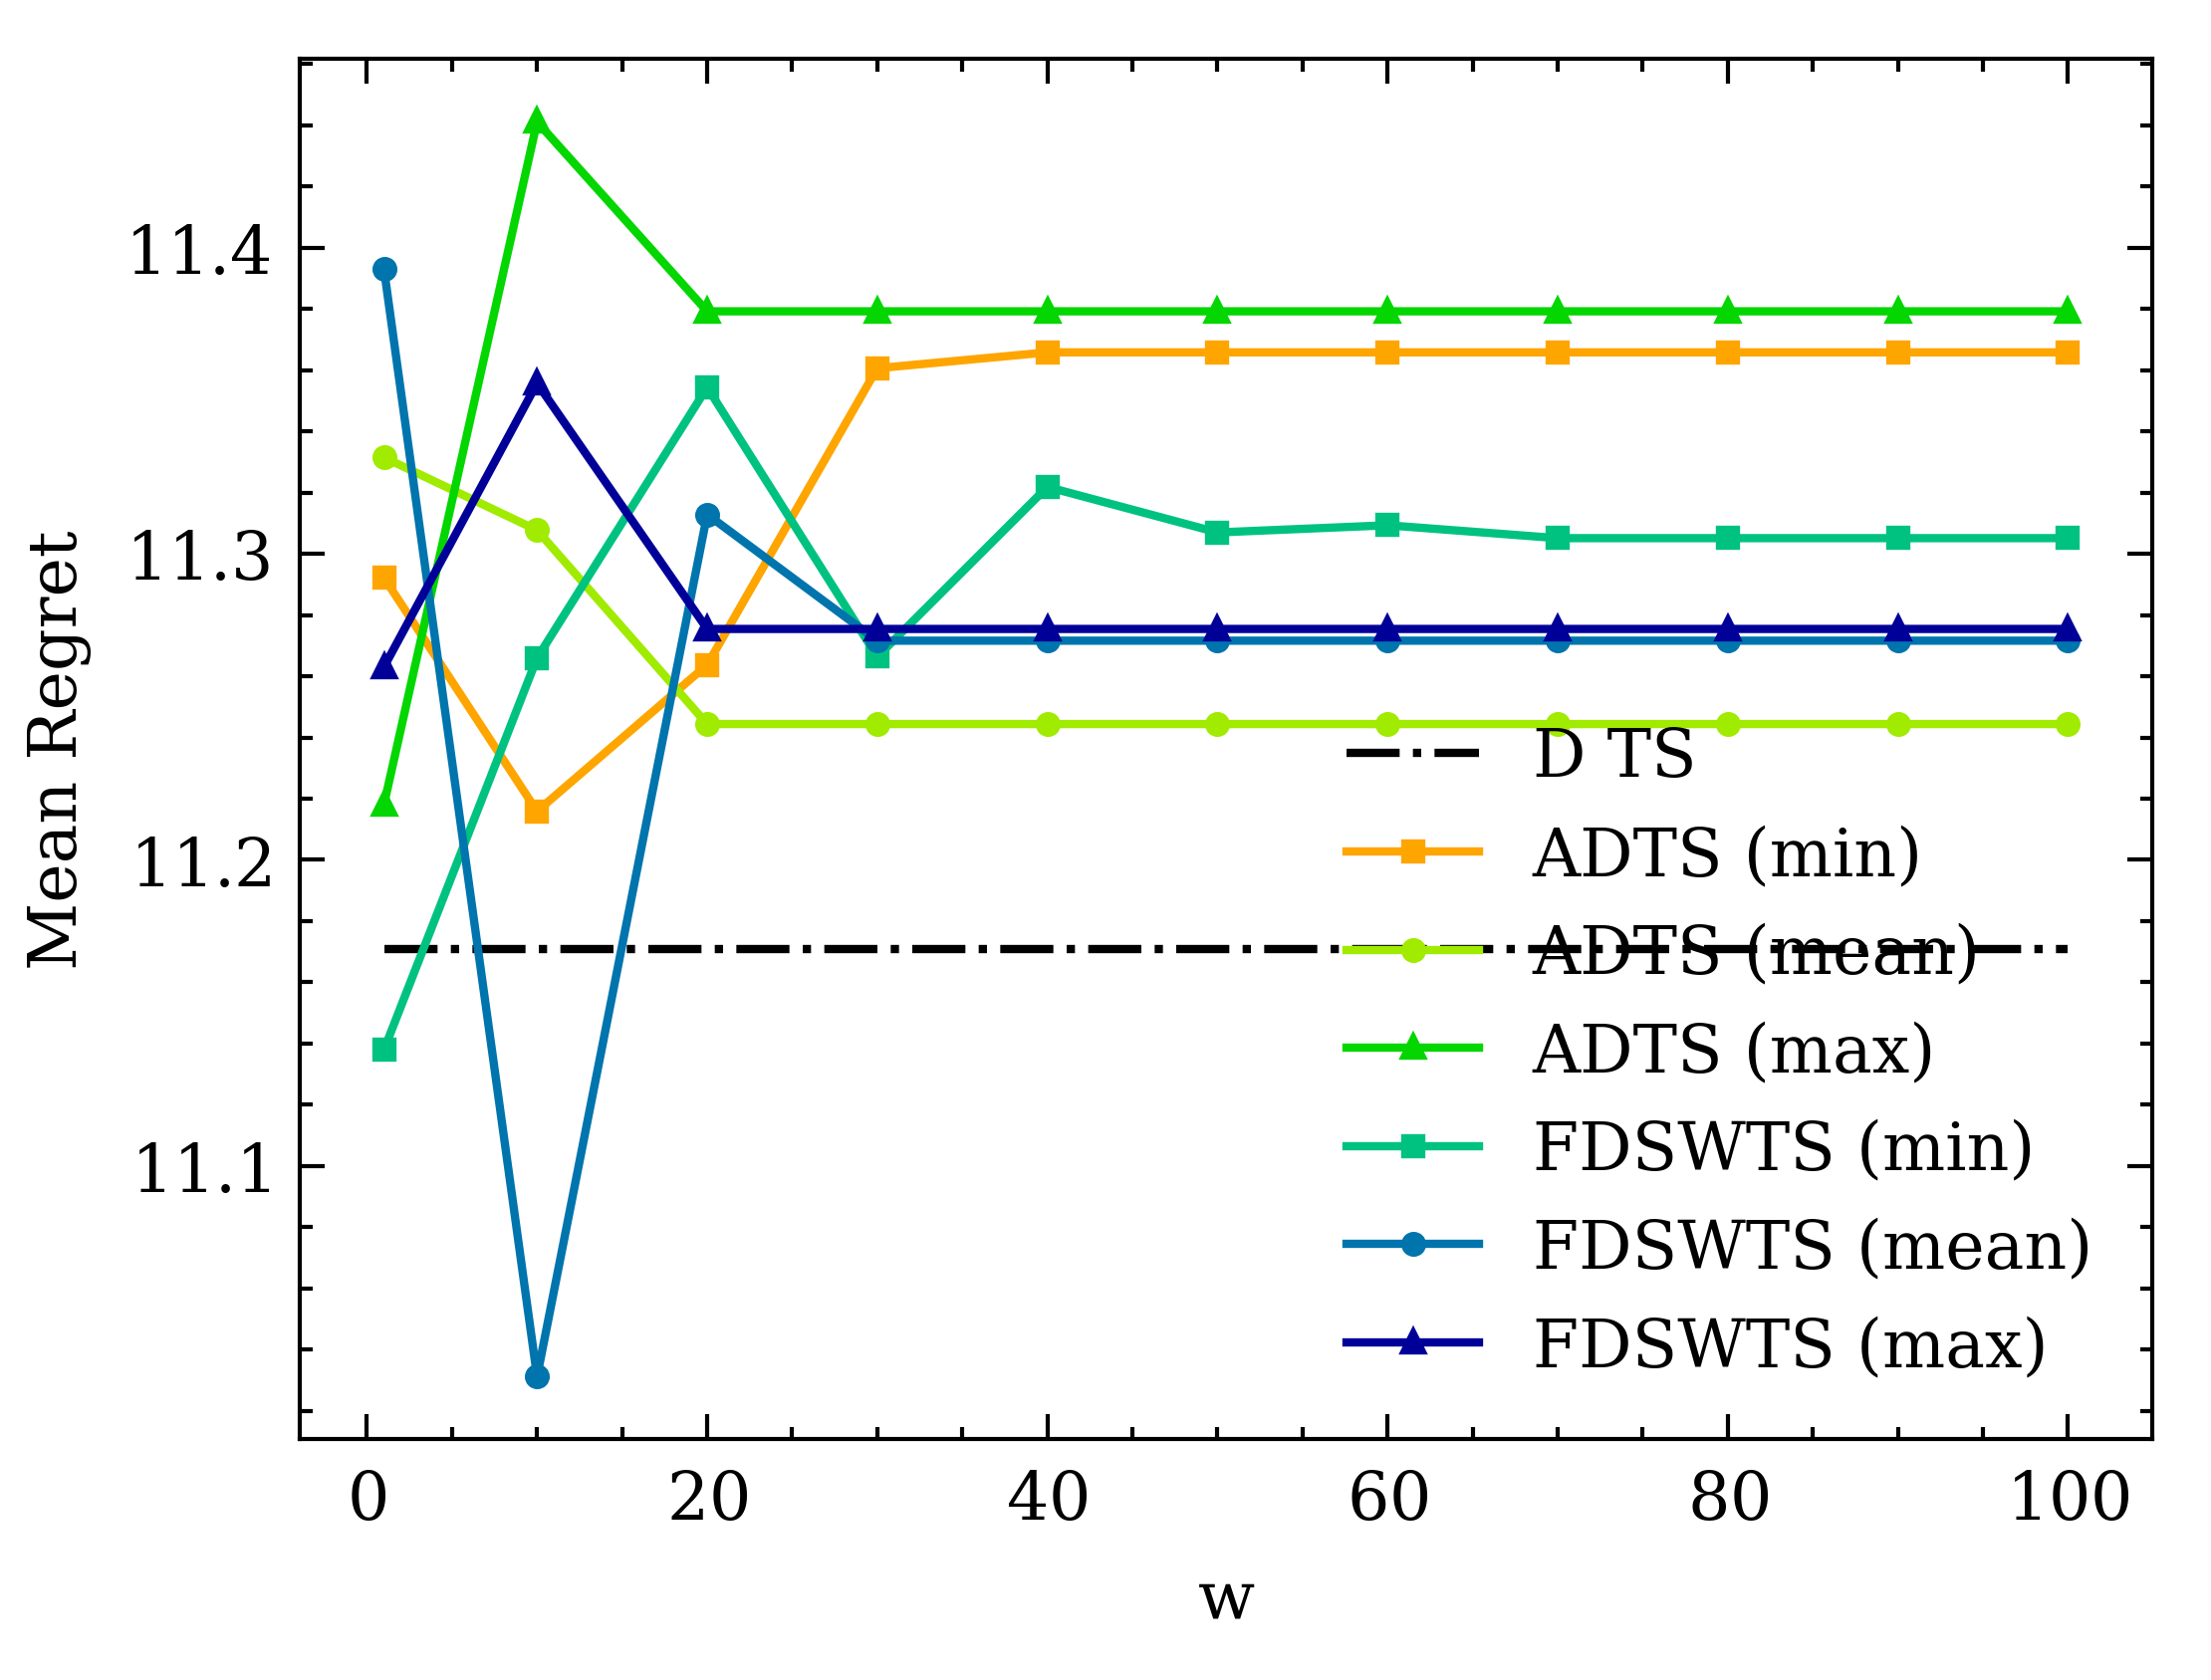

In [123]:
from colour import Color

blue = Color("orange")
colors = list(blue.range_to(Color("blue", luminance=0.3), len(results_dict)-1))

x_min = -10
x_max = 110
y_min = 0.
y_max = 0.4

with plt.style.context(['science', 'ieee', 'no-latex']):
    fig, ax = plt.subplots(figsize=(4, 3))
    legend = []
    i = 0
    plt.plot(results_dict["D TS"]["w_vec"], results_dict["D TS"]["regret"], color="k", linestyle="-.")
    plt.plot(results_dict["ADTS (min)"]["w_vec"], results_dict["ADTS (min)"]["regret"], "-s", markersize=2, color=colors[0].rgb, linestyle="-")
    plt.plot(results_dict["ADTS (mean)"]["w_vec"], results_dict["ADTS (mean)"]["regret"], "-o", markersize=2, color=colors[1].rgb, linestyle="-")
    plt.plot(results_dict["ADTS (max)"]["w_vec"], results_dict["ADTS (max)"]["regret"], "-^", markersize=2, color=colors[2].rgb, linestyle="-")
    plt.plot(results_dict["FDSWTS (min)"]["w_vec"], results_dict["FDSWTS (min)"]["regret"], "-s", markersize=2, color=colors[3].rgb, linestyle="-")
    plt.plot(results_dict["FDSWTS (mean)"]["w_vec"], results_dict["FDSWTS (mean)"]["regret"], "-o", markersize=2, color=colors[4].rgb, linestyle="-")
    plt.plot(results_dict["FDSWTS (max)"]["w_vec"], results_dict["FDSWTS (max)"]["regret"], "-^", markersize=2, color=colors[5].rgb, linestyle="-")
    
    # plt.plot([x_min, x_min], [y_min, y_max], color='r', linewidth=1, linestyle="--")
    # plt.plot([x_min, x_max], [y_max, y_max], color='r', linewidth=1, linestyle="--")
    # plt.plot([x_max, x_max], [y_min, y_max], color='r', linewidth=1, linestyle="--")
    # plt.plot([x_min, x_max], [y_min, y_min], color='r', linewidth=1, linestyle="--")
#     plt.plot(results_dict["d $\sigma$-TS"]["gamma_vec"], results_dict["d $\sigma$-TS"]["regret"], "-^", markersize=2, color=colors[2].rgb, linestyle="-.")
#     for k, v in results_dict.items():
#         plt.plot(v["gamma_vec"], v["regret"], color=colors[i].rgb, linestyle="-.")
#         plt.scatter(v["gamma_vec"], v["regret"], s=2, c=colors[i].rgb)#, linestyle="-.")
#         legend.append(k)
#         i+=1
    plt.xlabel('w')
    plt.ylabel('Mean Regret')
    plt.legend(["D TS", "ADTS (min)", "ADTS (mean)", "ADTS (max)", "FDSWTS (min)", "FDSWTS (mean)", "FDSWTS (max)"])
    plt.savefig('05_effect_of_w.jpg', dpi=600)

/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_24216/3473474818.py:10: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(results_dict["ADTS (min)"]["w_vec"], results_dict["ADTS (min)"]["regret"], "-s", markersize=2, color=colors[0].rgb, linestyle="-")
/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_24216/3473474818.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(results_dict["ADTS (mean)"]["w_vec"], results_dict["ADTS (mean)"]["regret"], "-o", markersize=2, color=colors[1].rgb, linestyle="-")
/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_24216/3473474818.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-^" (-> linestyle='-'). T

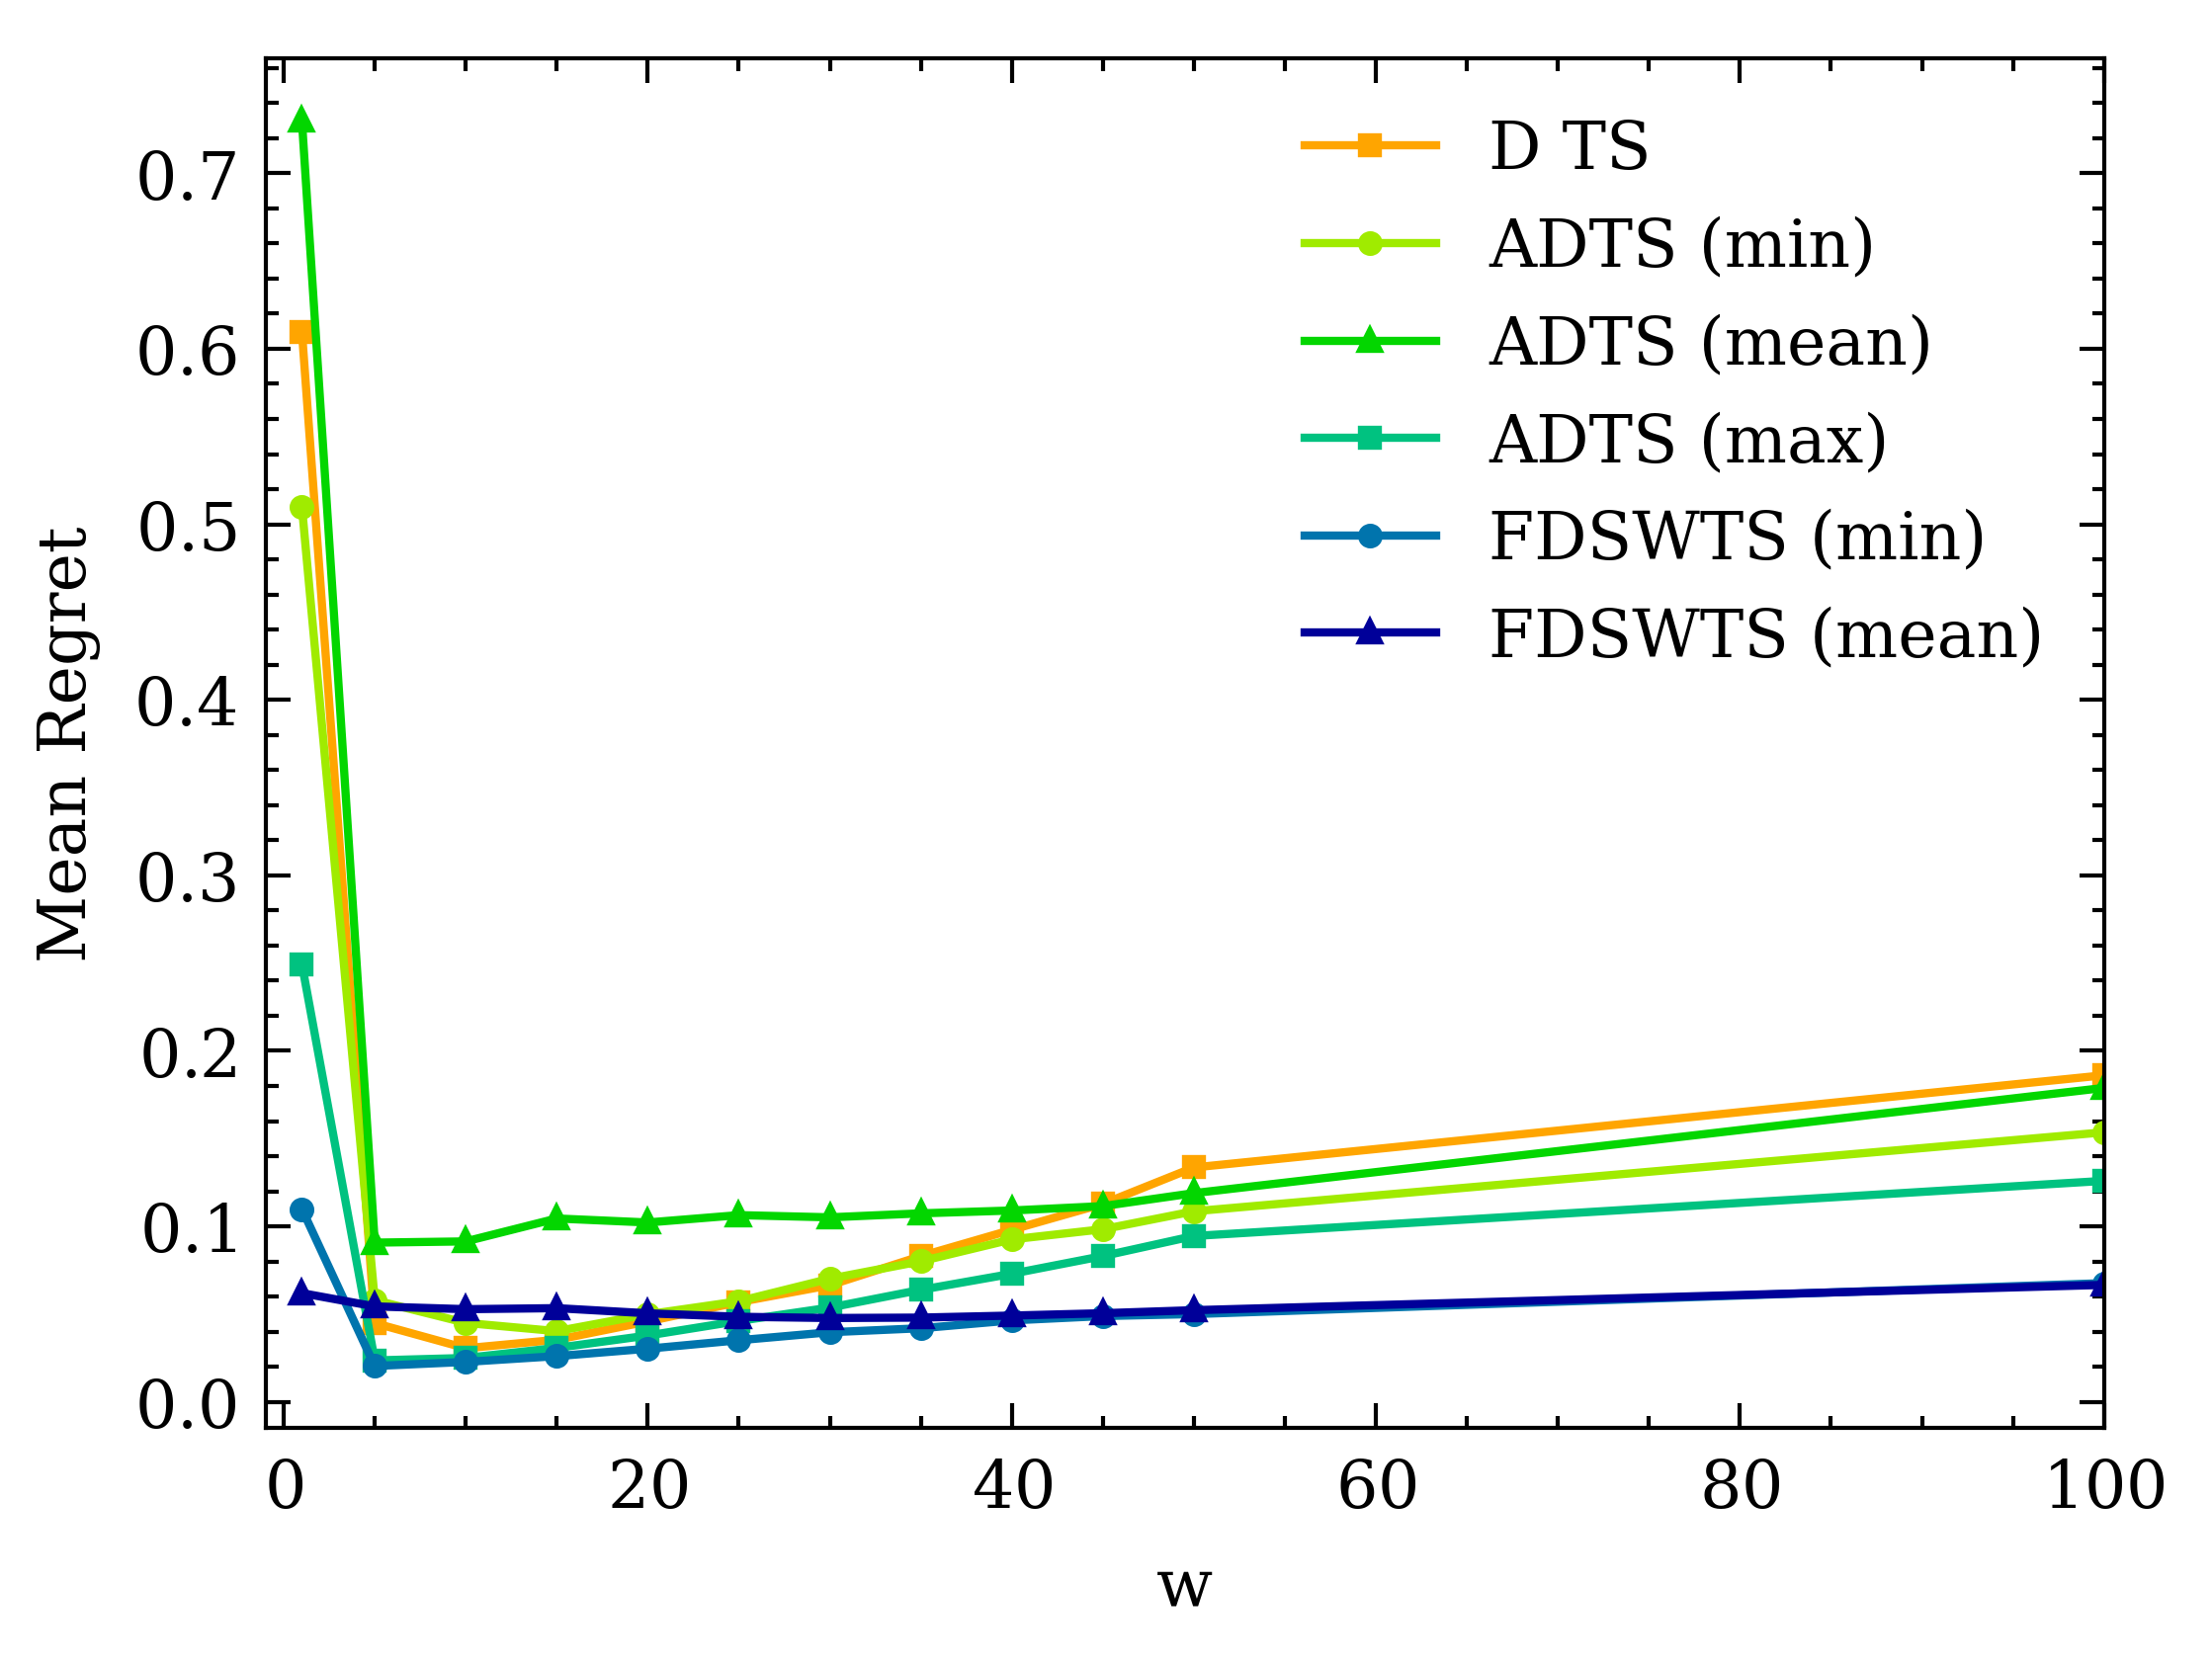

In [39]:
from colour import Color

blue = Color("orange")
colors = list(blue.range_to(Color("blue", luminance=0.3), len(results_dict)-1))

with plt.style.context(['science', 'ieee', 'no-latex']):
    fig, ax = plt.subplots(figsize=(4, 3))
    legend = []
    i = 0
    plt.plot(results_dict["ADTS (min)"]["w_vec"], results_dict["ADTS (min)"]["regret"], "-s", markersize=2, color=colors[0].rgb, linestyle="-")
    plt.plot(results_dict["ADTS (mean)"]["w_vec"], results_dict["ADTS (mean)"]["regret"], "-o", markersize=2, color=colors[1].rgb, linestyle="-")
    plt.plot(results_dict["ADTS (max)"]["w_vec"], results_dict["ADTS (max)"]["regret"], "-^", markersize=2, color=colors[2].rgb, linestyle="-")
    plt.plot(results_dict["FDSWTS (min)"]["w_vec"], results_dict["FDSWTS (min)"]["regret"], "-s", markersize=2, color=colors[3].rgb, linestyle="-")
    plt.plot(results_dict["FDSWTS (mean)"]["w_vec"], results_dict["FDSWTS (mean)"]["regret"], "-o", markersize=2, color=colors[4].rgb, linestyle="-")
    plt.plot(results_dict["FDSWTS (max)"]["w_vec"], results_dict["FDSWTS (max)"]["regret"], "-^", markersize=2, color=colors[5].rgb, linestyle="-")
    plt.xlabel('w')
    plt.ylabel('Mean Regret')
    plt.legend(["D TS", "ADTS (min)", "ADTS (mean)", "ADTS (max)", "FDSWTS (min)", "FDSWTS (mean)", "FDSWTS (max)"])
    plt.xlim([-1, 100])
    plt.savefig('05_effect_of_w_zoom_0_50.jpg', dpi=600)